In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from multiprocessing import Process
import random
from feature_selection import feature_ranking_algorithm
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/RFLFSODataFull.csv"
root_dir = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/"
original_data = pd.read_csv(data_path)
original_data.head()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


In [4]:
processed_data = original_data.copy()

# Time: directly convert to category type
processed_data['Time'] = processed_data['Time'].astype('category')

# SYNOPCode: directly convert to category type
processed_data['SYNOPCode'] = processed_data['SYNOPCode'].astype('category')

# Frequency: convert to GHz unit
processed_data['Frequency'] = processed_data['Frequency'] / 1e9


# prepare feature set (remove target variables)
feature_cols = [col for col in processed_data.columns 
               if col not in ['FSO_Att', 'RFL_Att']]

In [115]:
def plot_feature_selection_results(results_df, title, divide_feature, save_path=None):
    """
    plot the feature selection process
    
    Parameters:
    -----------
    results_df : DataFrame
        the dataframe containing the feature selection results
    title : str
        the title of the image
    save_path : str, optional
        if provided, save the image to the specified path
    """
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    # plot RMSE (blue line, left axis)
    line1 = ax1.plot(range(len(results_df)), 
                     results_df['oob_rmse'], 
                     color='blue', 
                     marker='o', 
                     label='RMSE')
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # plot R² (red line, right axis)
    line2 = ax2.plot(range(len(results_df)), 
                     results_df['oob_r2'], 
                     color='red', 
                     marker='o', 
                     label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')


    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['removed_feature'], rotation=90, ha='center')

    # find the position of Time and add a vertical line
    time_idx = results_df[results_df['removed_feature'] == divide_feature].index[0]
    ax1.axvline(x=time_idx - 0.5,  # subtract 0.5 from x value !!
                color='green', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                label='Time Position')

    lines = line1 + line2 + [ax1.get_lines()[-1]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(title)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()





def load_and_plot_single_result(target_type, synop_code, divide_feature, method='method1'):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' 或 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'results_{target_type.lower()}'
    result_file = f'synop_{synop_code}_results.pkl'
    
    # load results
    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    
    # create image title
    title = f'Feature Selection Results for SYNOP {synop_code} ({target_type})'
    
    save_path = os.path.join(result_dir, f'{target_type.lower()}_{method}_{synop_code}.png')
    
    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide

def load_and_plot_method3_result(target_type, divide_feature):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' or 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'method3'
    result_file = f'results_{target_type.lower()}_method3.pkl'
    

    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    

    title = f'Feature Selection Results for {target_type} Method 3 ({divide_feature})'
    

    save_path = os.path.join(result_dir, f'{target_type}_method3_plot.png')
    

    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide



In [11]:
def gene_final_X_y(important_features, target_type, synop_code=None):
    if synop_code is None:
        # actually, method2
        group_data = processed_data
    else:
        # actually, method1
        group_data = processed_data[processed_data['SYNOPCode'] == synop_code]
    
    X = group_data[important_features]
    y = group_data[target_type]
    return X, y

from sklearn.metrics import make_scorer
def tune_random_forest(X, y, param_grid=None, cv=5, verbose=True):
    """
    tune the hyperparameters of the random forest model
    
    Parameters:
    -----------
    X : feature data
    y : target variable
    param_grid : hyperparameter grid, if None, use the default grid
    cv : number of cross-validation folds
    verbose : whether to print detailed information
    
    Returns:
    --------
    dict : a dictionary containing the best model and performance metrics
    """
    # if param_grid is None, use the default grid
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [None, 10, 20]
        }
    
    if verbose:
        print("Start tuning...")
        print(f"Dataset size: {X.shape}")
        print("Parameter grid:", param_grid)
        print("\n" + "-"*80)
        print(f"{'n_estimators':>12} | {'max_depth':>9} | {'OOB Score':>9} | {'OOB R²':>9} | {'OOB RMSE':>9}")
        print("-"*80)

    results = []


    # nested loop to iterate through all parameter combinations
    for n_trees in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            # train model
            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_depth=max_depth,
                random_state=42,
                oob_score=True,
                n_jobs=-1
            )
            rf.fit(X, y)
            
            # get OOB prediction and scores
            oob_score = rf.oob_score_
            y_pred = rf.oob_prediction_
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            
            results.append({
                'n_estimators': n_trees,
                'max_depth': max_depth,
                'oob_score': oob_score,
                'r2': r2,
                'rmse': rmse,
                'model': rf
            })
            
            if verbose:
                print(f"{n_trees:>12} | {str(max_depth):>9} | {oob_score:>9.6f} | {r2:>9.6f} | {rmse:>9.6f}")
    

    best_result = max(results, key=lambda x: x['oob_score'])

    if verbose:
        print("\nBest result:")
        print(f"Best parameters: n_estimators={best_result['n_estimators']}, max_depth={best_result['max_depth']}")
        print(f"Best OOB Score: {best_result['oob_score']:.6f}")
        print(f"Best OOB R² Score: {best_result['r2']:.6f}")
        print(f"Best OOB RMSE: {best_result['rmse']:.6f}")
    
    return {
        'best_params': {
            'n_estimators': best_result['n_estimators'],
            'max_depth': best_result['max_depth']
        },
        'best_oob_score': best_result['oob_score'],
        'final_model': best_result['model'],
        'oob_r2_score': best_result['r2'],
        'oob_rmse': best_result['rmse'],
        'results': results
    }



# method 3 for fso

In [8]:
X_fso_method3 = processed_data[feature_cols+['RFL_Att']]
y_fso_method3 = processed_data['FSO_Att']

results_fso_method3 = feature_ranking_algorithm(X_fso_method3, y_fso_method3, n_jobs=-1)
# save results_rfl_method2 to pickle
with open('method3/results_fso_method3.pkl', 'wb') as f:
    pickle.dump(results_fso_method3, f)

1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


FileNotFoundError: [Errno 2] No such file or directory: 'method3/results_fso_method3.pkl'

In [ ]:
# rlf method2 pred & fso method2 pred (benchmark) & fso method3 pred

model2 feature -> rfl

In [109]:
feature_mod2_rfl = ['AbsoluteHumidity','Distance', 'Frequency', 'ParticulateMax', 'RainIntensity', 'RainIntensityMax',
 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureMax', 'Visibility']

In [110]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(processed_data.index, test_size=0.2, random_state=42)

In [ ]:
#train test split
synop,_ = gene_final_X_y(['SYNOPCode'], 'RFL_Att')
X_rfl_method2, y_rfl_method2 = gene_final_X_y(feature_mod2_rfl, 'RFL_Att')
x_train_rfl_method2, y_train_rfl_method2 = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl_method2, y_test_rfl_method2 = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]
synop_train = synop.loc[train_idx]
synop_test = synop.loc[test_idx]
rfl_method2_tune = tune_random_forest(
    x_train_rfl_method2, 
    y_train_rfl_method2,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
y_pred_rfl_method2 = rfl_method2_best_model.predict(x_test_rfl_method2)

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.972084 |  0.972084 |  0.574440
         100 |        10 |  0.958478 |  0.958478 |  0.700575
         100 |        20 |  0.971959 |  0.971959 |  0.575728
         150 |      None |  0.972465 |  0.972465 |  0.570505
         150 |        10 |  0.958752 |  0.958752 |  0.698262
         150 |        20 |  0.972465 |  0.972465 |  0.570511

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.972465
Best OOB R² Score: 0.972465
Best OOB RMSE: 0.570505


model3 feature+rfl -> fso

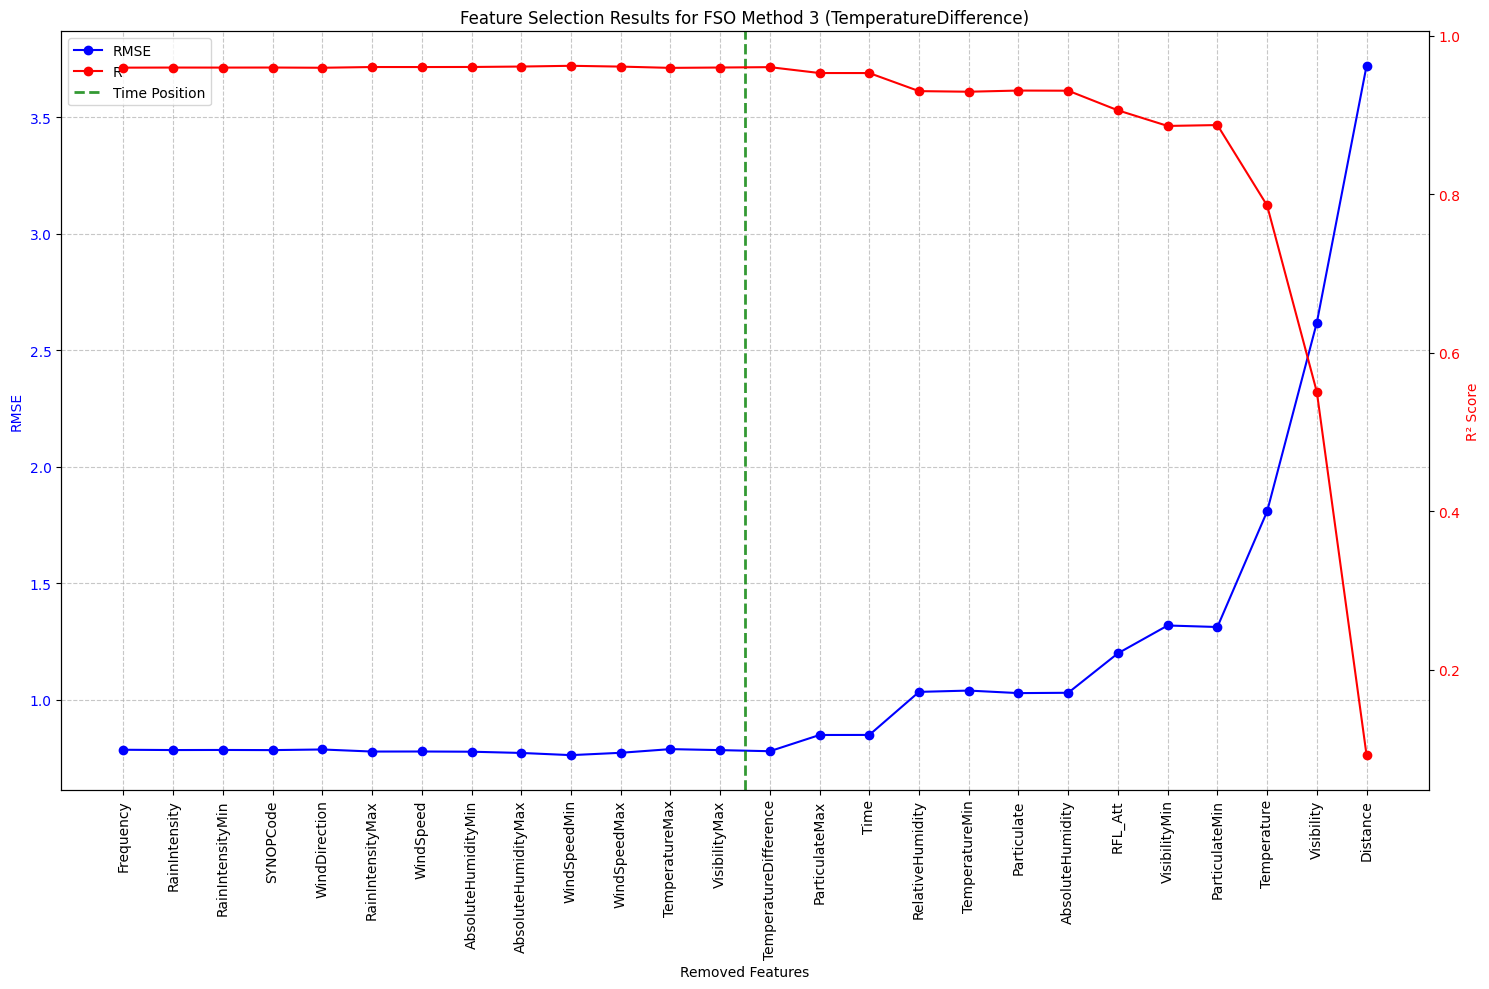

In [116]:
important_features_fso_method3 = load_and_plot_method3_result('FSO', 'TemperatureDifference')

In [117]:
#train test split
X_fso_method3, y_fso_method3 = gene_final_X_y(important_features_fso_method3, 'FSO_Att')
x_train_fso_method3,y_train_fso_method3 = X_fso_method3.loc[train_idx], y_fso_method3.loc[train_idx]
x_test_fso_method3,y_test_fso_method3 = X_fso_method3.loc[test_idx], y_fso_method3.loc[test_idx]

fso_method3_tune = tune_random_forest(
    x_train_fso_method3, 
    y_train_fso_method3,
    cv=5,
    verbose=True
)

fso_method3_best_model = fso_method3_tune['final_model']

Start tuning...
Dataset size: (73103, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.954379 |  0.954379 |  0.835420
         100 |        10 |  0.899122 |  0.899122 |  1.242282
         100 |        20 |  0.952505 |  0.952505 |  0.852406
         150 |      None |  0.954883 |  0.954883 |  0.830796
         150 |        10 |  0.898934 |  0.898934 |  1.243441
         150 |        20 |  0.952982 |  0.952982 |  0.848112

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.954883
Best OOB R² Score: 0.954883
Best OOB RMSE: 0.830796


In [118]:
# test R² and RMSE
r2_fso_method3 = r2_score(y_test_fso_method3, fso_method3_best_model.predict(x_test_fso_method3))
rmse_fso_method3 = np.sqrt(mean_squared_error(y_test_fso_method3, fso_method3_best_model.predict(x_test_fso_method3)))
print(f"FSO Method 3 R²: {r2_fso_method3:.6f}")
print(f"FSO Method 3 RMSE: {rmse_fso_method3:.6f}")

FSO Method 3 R²: 0.957628
FSO Method 3 RMSE: 0.797334


predict

In [119]:
x_test_fso_method3['RFL_Att'] = y_pred_rfl_method2
y_fso_pred_model3 = fso_method3_best_model.predict(x_test_fso_method3)

In [120]:
#benchmark model2 for fso
important_features_fso_method2 = ['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax',
 'ParticulateMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin', 'Time', 'Visibility','VisibilityMin']

X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2, 'FSO_Att')
x_train_fso_method2, y_train_fso_method2 = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso_method2, y_test_fso_method2 = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

fso_method2_tune = tune_random_forest(
    x_train_fso_method2, 
    y_train_fso_method2,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']

y_fso_pred_method2 = fso_method2_best_model.predict(x_test_fso_method2)

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.957580 |  0.957580 |  0.805578
         100 |        10 |  0.904450 |  0.904450 |  1.209031
         100 |        20 |  0.956097 |  0.956097 |  0.819536
         150 |      None |  0.958171 |  0.958171 |  0.799952
         150 |        10 |  0.904530 |  0.904530 |  1.208527
         150 |        20 |  0.956659 |  0.956659 |  0.814279

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.958171
Best OOB R² Score: 0.958171
Best OOB RMSE: 0.799952


In [121]:
r2_fso_method2 = r2_score(y_test_fso_method2, y_fso_pred_method2)
rmse_fso_method2 = np.sqrt(mean_squared_error(y_test_fso_method2, y_fso_pred_method2))
print(f"FSO Method 2 R²: {r2_fso_method2:.6f}")
print(f"FSO Method 2 RMSE: {rmse_fso_method2:.6f}")

FSO Method 2 R²: 0.960340
FSO Method 2 RMSE: 0.771396


Text(0.5, 1.0, 'Method 3 (PCC=0.0897)')

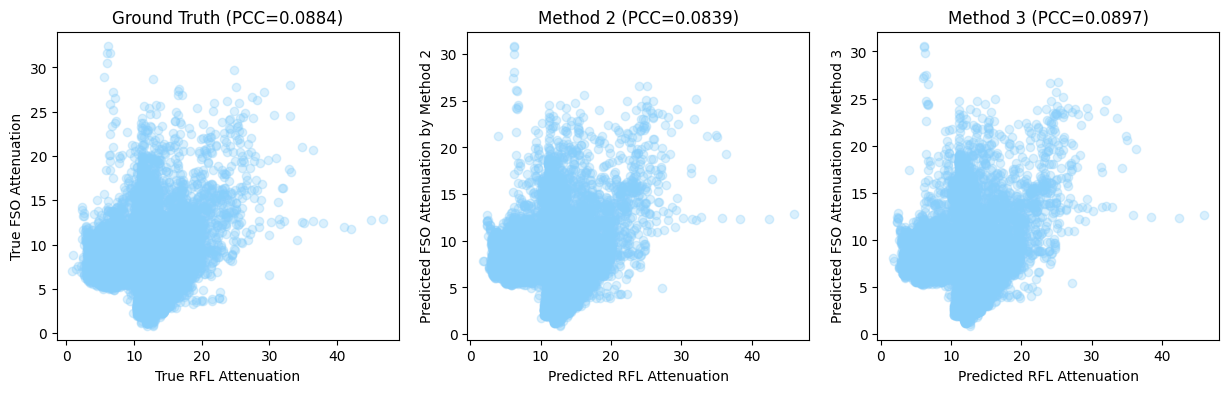

In [122]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)

plt.scatter(y_test_rfl_method2, y_test_fso_method2, color='lightskyblue', label='Ground Truth',alpha=0.3)
pcc_true = np.corrcoef(y_test_rfl_method2, y_test_fso_method2)[0, 1]
plt.xlabel('True RFL Attenuation')
plt.ylabel('True FSO Attenuation')
plt.title(f'Ground Truth (PCC={pcc_true:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_pred_rfl_method2, y_fso_pred_method2, color='lightskyblue', label='Method 2',alpha=0.3)
pcc_method2 = np.corrcoef(y_pred_rfl_method2, y_fso_pred_method2)[0, 1]
plt.xlabel('Predicted RFL Attenuation')
plt.ylabel('Predicted FSO Attenuation by Method 2')
plt.title(f'Method 2 (PCC={pcc_method2:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_rfl_method2, y_fso_pred_model3, color='lightskyblue', label='Method 3',alpha=0.3)
pcc_method3 = np.corrcoef(y_pred_rfl_method2, y_fso_pred_model3)[0, 1]
plt.xlabel('Predicted RFL Attenuation')
plt.ylabel('Predicted FSO Attenuation by Method 3')
plt.title(f'Method 3 (PCC={pcc_method3:.4f})')


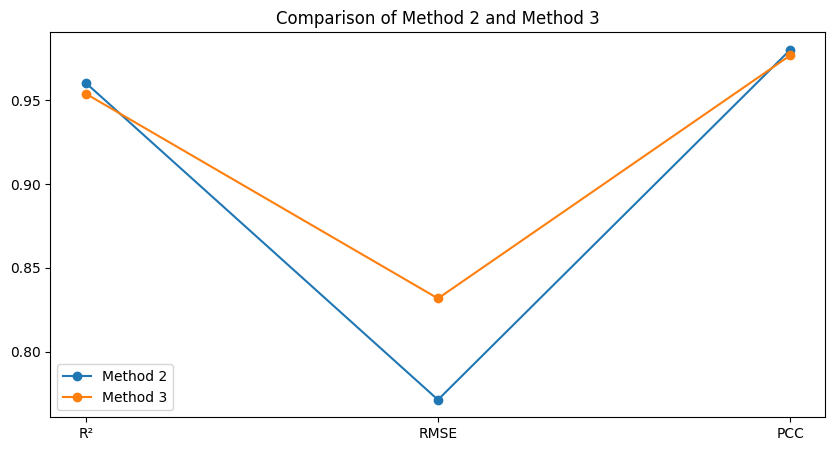

In [96]:
plt.figure(figsize=(10, 5))
# R2 RMSE PCC plot for 2 methods
plt.plot([r2_fso_method2, rmse_fso_method2, pcc_method2], label='Method 2', marker='o')
plt.plot([r2_fso_method3, rmse_fso_method3, pcc_method3], label='Method 3', marker='o')
plt.xticks(range(3), ['R²', 'RMSE', 'PCC'])
plt.legend()
plt.title('Comparison of Method 2 and Method 3')
plt.show()

Text(0.5, 1.0, 'Method 3 (PCC=0.9767)')

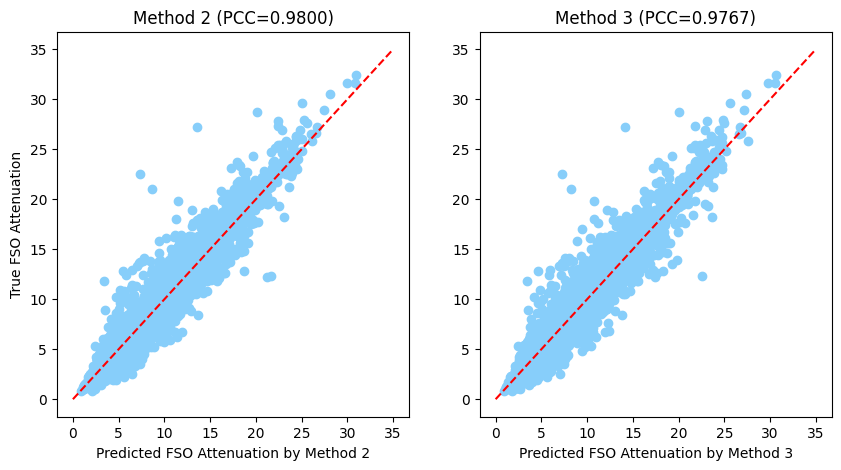

In [93]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.scatter(y_fso_pred_method2, y_test_fso_method2, color='lightskyblue', label='Method 2')
plt.plot([0, 35], [0, 35], color='red', linestyle='--', label='y=x')
pcc_method2 = np.corrcoef(y_test_fso_method2, y_fso_pred_method2)[0, 1]
plt.ylabel('True FSO Attenuation')
plt.xlabel('Predicted FSO Attenuation by Method 2')
plt.title(f'Method 2 (PCC={pcc_method2:.4f})')

plt.subplot(1, 2, 2)
plt.scatter(y_fso_pred_model3, y_test_fso_method2, color='lightskyblue', label='Method 3')
plt.plot([0, 35], [0, 35], color='red', linestyle='--', label='y=x')
pcc_method3 = np.corrcoef(y_test_fso_method2, y_fso_pred_model3)[0, 1]
plt.xlabel('Predicted FSO Attenuation by Method 3')
plt.title(f'Method 3 (PCC={pcc_method3:.4f})')


In [107]:
y_pred_rfl_method2,y_fso_pred_method2,y_fso_pred_model3

(array([10.9926711 , 12.55296101, 15.88835189, ..., 11.96210621,
        11.86117166, 16.24428028]),
 array([3.52238585, 3.54223623, 5.88038673, ..., 6.88697243, 2.74251041,
        6.47994389]),
 array([3.49949153, 3.52962641, 5.87921993, ..., 6.70541048, 2.78327506,
        6.47476073]))

In [128]:
pcc_true = []
pcc_method2 = []
pcc_method3 = []

for sy in [0,3,4,5,6,7,8]:
    sy_index = synop_test['SYNOPCode'] == sy
    y_pred_rfl_method2_sy = y_pred_rfl_method2[sy_index]
    y_fso_pred_method2_sy = y_fso_pred_method2[sy_index]
    y_fso_pred_model3_sy = y_fso_pred_model3[sy_index]
    y_test_rfl_method2_sy = y_test_rfl_method2[sy_index]
    y_test_fso_method2_sy = y_test_fso_method2[sy_index]

    true_pcc = np.corrcoef(y_test_rfl_method2_sy, y_test_fso_method2_sy)[0, 1]
    method2_pcc = np.corrcoef(y_pred_rfl_method2_sy, y_fso_pred_method2_sy)[0, 1]
    method3_pcc = np.corrcoef(y_pred_rfl_method2_sy, y_fso_pred_model3_sy)[0, 1]

    pcc_true.append(true_pcc)
    pcc_method2.append(method2_pcc)
    pcc_method3.append(method3_pcc)

Text(0.5, 1.0, 'Method 3 (PCC=0.8176)')

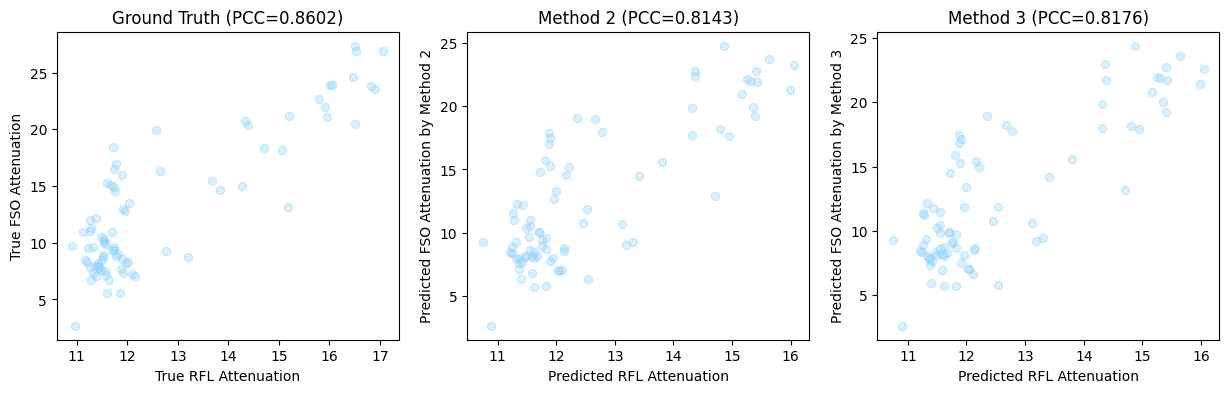

In [137]:
sy =7

sy_index = synop_test['SYNOPCode'] == sy
y_pred_rfl_method2_sy = y_pred_rfl_method2[sy_index]
y_fso_pred_method2_sy = y_fso_pred_method2[sy_index]
y_fso_pred_model3_sy = y_fso_pred_model3[sy_index]
y_test_rfl_method2_sy = y_test_rfl_method2[sy_index]
y_test_fso_method2_sy = y_test_fso_method2[sy_index]

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)

plt.scatter(y_test_rfl_method2_sy, y_test_fso_method2_sy, color='lightskyblue', label='Ground Truth',alpha=0.3)
pcc_true = np.corrcoef(y_test_rfl_method2_sy, y_test_fso_method2_sy)[0, 1]
plt.xlabel('True RFL Attenuation')
plt.ylabel('True FSO Attenuation')
plt.title(f'Ground Truth (PCC={pcc_true:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_pred_rfl_method2_sy, y_fso_pred_method2_sy, color='lightskyblue', label='Method 2',alpha=0.3)
pcc_method2 = np.corrcoef(y_pred_rfl_method2_sy, y_fso_pred_method2_sy)[0, 1]
plt.xlabel('Predicted RFL Attenuation')
plt.ylabel('Predicted FSO Attenuation by Method 2')
plt.title(f'Method 2 (PCC={pcc_method2:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_rfl_method2_sy, y_fso_pred_model3_sy, color='lightskyblue', label='Method 3',alpha=0.3)
pcc_method3 = np.corrcoef(y_pred_rfl_method2_sy, y_fso_pred_model3_sy)[0, 1]
plt.xlabel('Predicted RFL Attenuation')
plt.ylabel('Predicted FSO Attenuation by Method 3')
plt.title(f'Method 3 (PCC={pcc_method3:.4f})')


In [62]:
X_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == 7][feature_cols+['RFL_Att']]
y_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == 7]['FSO_Att']
results_fso_method3_sy7 = feature_ranking_algorithm(X_fso_method3_sy7, y_fso_method3_sy7, n_jobs=-1)
# save results_rfl_method2 to pickle
with open('method3/results_fso_method3_sy7.pkl', 'wb') as f:
    pickle.dump(results_fso_method3_sy7, f)

1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


In [78]:
train_idx, test_idx = train_test_split(processed_data[processed_data['SYNOPCode'] == 7].index, test_size=0.2)

In [79]:
important_features_rfl_method1_synop_7 =['AbsoluteHumidity', 'AbsoluteHumidityMax', 'Frequency', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin',
 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'Time', 'VisibilityMin', 'WindSpeedMax']

In [80]:
#train test split
X_rfl_method1_sy7, y_rfl_method1_sy7 = gene_final_X_y(important_features_rfl_method1_synop_7, 'RFL_Att',7)
x_train_rfl_method1_sy7, y_train_rfl_method1_sy7 = X_rfl_method1_sy7.loc[train_idx], y_rfl_method1_sy7.loc[train_idx]
x_test_rfl_method1_sy7, y_test_rfl_method1_sy7 = X_rfl_method1_sy7.loc[test_idx], y_rfl_method1_sy7.loc[test_idx]

rfl_method1_sy7_tune = tune_random_forest(
    x_train_rfl_method1_sy7, 
    y_train_rfl_method1_sy7,
    cv=5,
    verbose=True
)

rfl_method1_sy7_best_model = rfl_method1_sy7_tune['final_model']
y_pred_rfl_method1_sy7 = rfl_method1_sy7_best_model.predict(x_test_rfl_method1_sy7)

Start tuning...
Dataset size: (335, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.954107 |  0.954107 |  0.332583
         100 |        10 |  0.953478 |  0.953478 |  0.334854
         100 |        20 |  0.954107 |  0.954107 |  0.332583
         150 |      None |  0.956637 |  0.956637 |  0.323286
         150 |        10 |  0.956348 |  0.956348 |  0.324360
         150 |        20 |  0.956637 |  0.956637 |  0.323286

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.956637
Best OOB R² Score: 0.956637
Best OOB RMSE: 0.323286


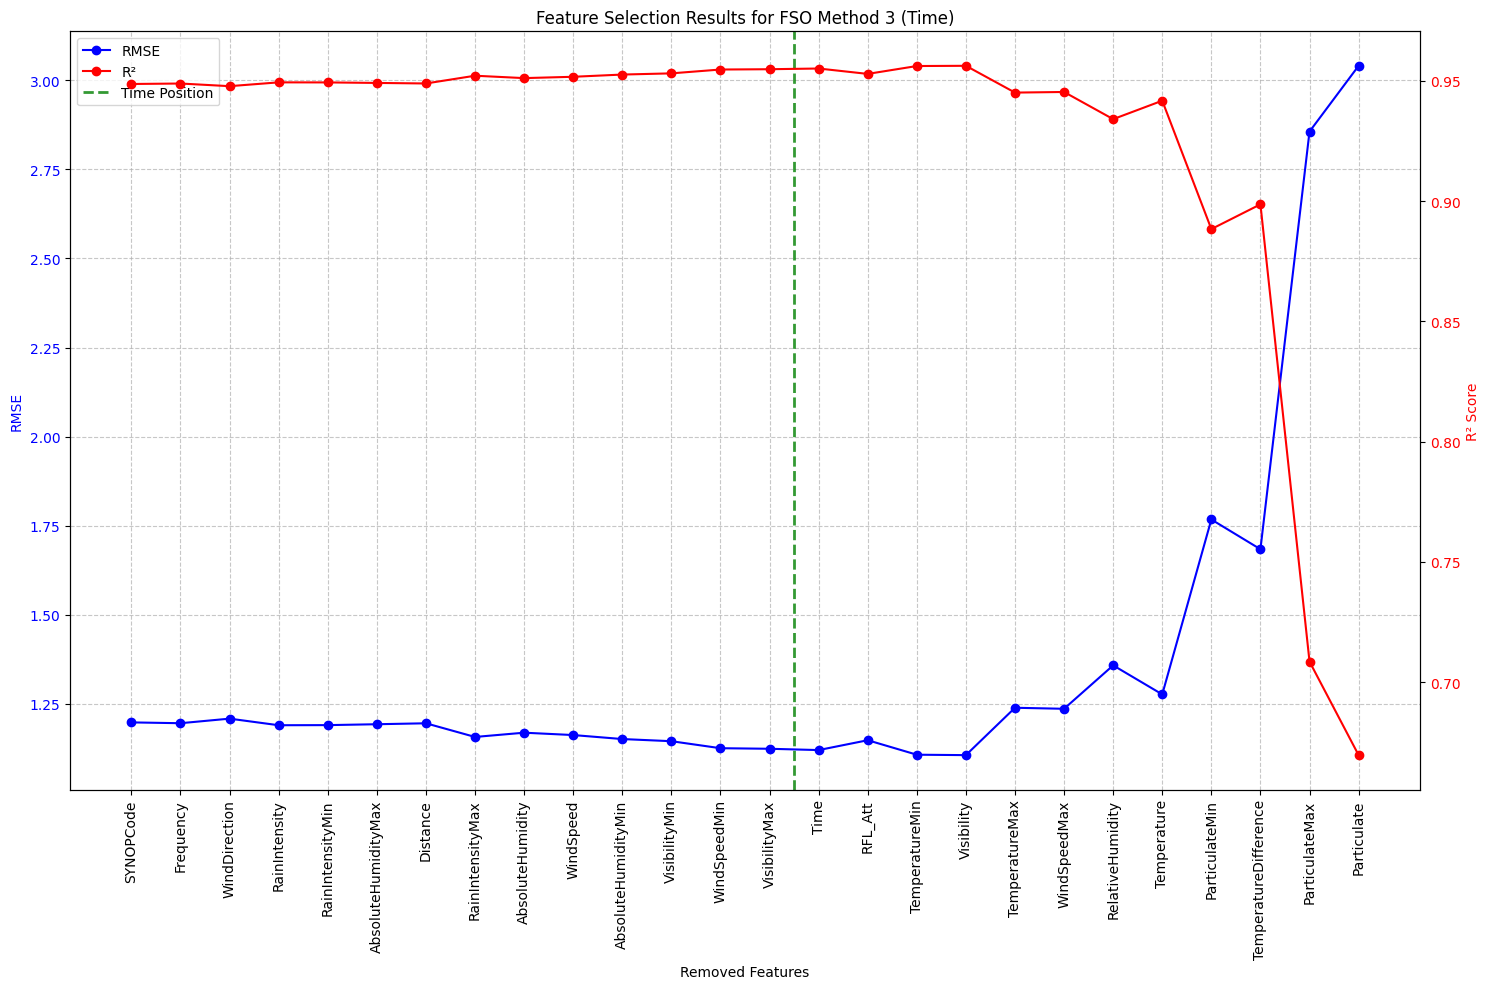

In [81]:
important_features_fso_method3_sy7 = load_and_plot_method3_result('FSO', 'Time')

In [82]:
#train test split
X_fso_method3_sy7, y_fso_method3_sy7 = gene_final_X_y(important_features_fso_method3_sy7, 'FSO_Att',7)
x_train_fso_method3_sy7,y_train_fso_method3_sy7 = X_fso_method3_sy7.loc[train_idx], y_fso_method3_sy7.loc[train_idx]
x_test_fso_method3_sy7,y_test_fso_method3_sy7 = X_fso_method3_sy7.loc[test_idx], y_fso_method3_sy7.loc[test_idx]

fso_method3_tune_sy7 = tune_random_forest(
    x_train_fso_method3_sy7, 
    y_train_fso_method3_sy7,
    cv=5,
    verbose=True
)

fso_method3_best_model_sy7 = fso_method3_tune_sy7['final_model']

Start tuning...
Dataset size: (335, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.959102 |  0.959102 |  1.080746
         100 |        10 |  0.959586 |  0.959586 |  1.074325
         100 |        20 |  0.959285 |  0.959285 |  1.078324
         150 |      None |  0.960915 |  0.960915 |  1.056521
         150 |        10 |  0.960789 |  0.960789 |  1.058214
         150 |        20 |  0.960944 |  0.960944 |  1.056130

Best result:
Best parameters: n_estimators=150, max_depth=20
Best OOB Score: 0.960944
Best OOB R² Score: 0.960944
Best OOB RMSE: 1.056130


In [83]:
x_test_fso_method3_sy7['RFL_Att'] = y_pred_rfl_method1_sy7
y_fso_pred_model3_sy7 = fso_method3_best_model_sy7.predict(x_test_fso_method3_sy7)

In [84]:
#benchmark model2 for fso
important_features_fso_method1_sy7 = ['Particulate', 'ParticulateMax', 'ParticulateMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin',
 'Visibility', 'WindSpeedMax']

X_fso_method1_sy7, y_fso_method1_sy7 = gene_final_X_y(important_features_fso_method1_sy7, 'FSO_Att',7)
x_train_fso_method1_sy7, y_train_fso_method1_sy7 = X_fso_method1_sy7.loc[train_idx], y_fso_method1_sy7.loc[train_idx]
x_test_fso_method1_sy7, y_test_fso_method1_sy7 = X_fso_method1_sy7.loc[test_idx], y_fso_method1_sy7.loc[test_idx]

fso_method1_sy7_tune = tune_random_forest(
    x_train_fso_method1_sy7, 
    y_train_fso_method1_sy7,
    cv=5,
    verbose=True
)

fso_method1_sy7_best_model = fso_method1_sy7_tune['final_model']

y_fso_pred_method1_sy7 = fso_method1_sy7_best_model.predict(x_test_fso_method1_sy7)

Start tuning...
Dataset size: (335, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.959801 |  0.959801 |  1.071471
         100 |        10 |  0.960127 |  0.960127 |  1.067106
         100 |        20 |  0.959841 |  0.959841 |  1.070939
         150 |      None |  0.962669 |  0.962669 |  1.032536
         150 |        10 |  0.962784 |  0.962784 |  1.030952
         150 |        20 |  0.962715 |  0.962715 |  1.031905

Best result:
Best parameters: n_estimators=150, max_depth=10
Best OOB Score: 0.962784
Best OOB R² Score: 0.962784
Best OOB RMSE: 1.030952


Text(0.5, 1.0, 'Method 3 (PCC=0.8104)')

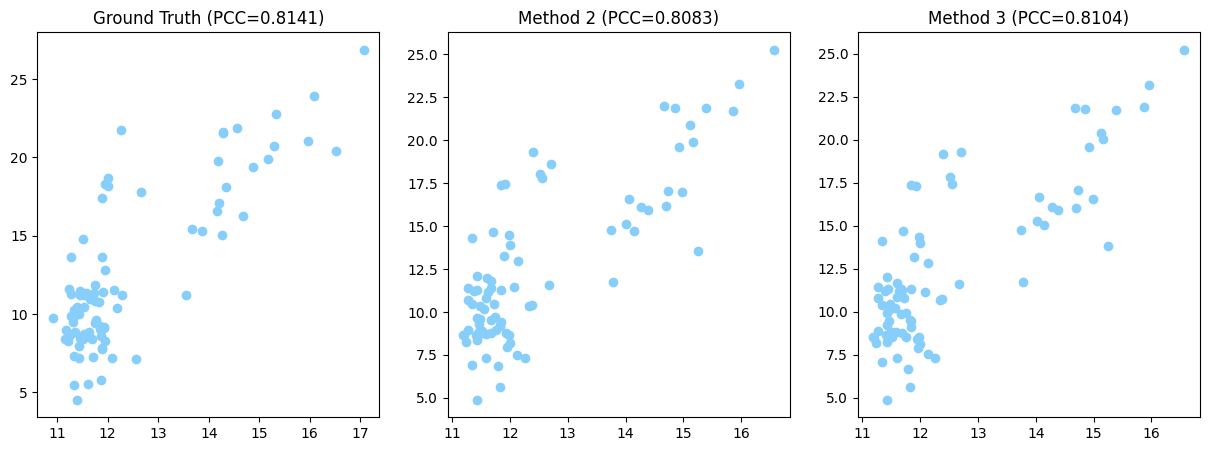

In [85]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.scatter(y_test_rfl_method1_sy7, y_test_fso_method3_sy7, color='lightskyblue', label='Ground Truth')
pcc_true = np.corrcoef(y_test_rfl_method1_sy7, y_test_fso_method3_sy7)[0, 1]
plt.title(f'Ground Truth (PCC={pcc_true:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_pred_rfl_method1_sy7, y_fso_pred_method1_sy7, color='lightskyblue', label='Method 2')
pcc_method2 = np.corrcoef(y_pred_rfl_method1_sy7, y_fso_pred_method1_sy7)[0, 1]
plt.title(f'Method 2 (PCC={pcc_method2:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_rfl_method1_sy7, y_fso_pred_model3_sy7, color='lightskyblue', label='Method 3')
pcc_method3 = np.corrcoef(y_pred_rfl_method1_sy7, y_fso_pred_model3_sy7)[0, 1]
plt.title(f'Method 3 (PCC={pcc_method3:.4f})')


In [86]:
processed_data

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83.5,0.000000,0.000000,0.000000,...,26.603030,24.680849,9,65884.518460,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73.5,0.000000,0.000000,0.000000,...,26.377164,24.313108,9,64963.410920,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83.5,0.000000,0.000000,0.000000,...,27.670822,23.150277,10,54794.281070,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73.5,0.000000,0.000000,0.000000,...,26.522100,23.174815,10,50205.641590,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83.5,0.000000,0.000000,0.000000,...,26.305736,24.864100,10,59038.325990,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91374,9.150012,11.968291,23.283256,24.142871,22.169805,3970.846129,83.5,0.000000,0.000000,0.000000,...,27.257926,26.013205,4,13041.847800,13458.340663,12411.852994,91.391749,0.000000,0.027596,0.000000
91375,9.333777,11.538030,23.259618,25.104895,21.005496,3969.230652,73.5,0.000000,0.000000,0.000000,...,28.101044,25.032282,4,15959.633590,16232.735439,15345.485232,47.997946,0.075640,0.349551,0.069834
91376,8.873168,11.491891,23.331697,23.996130,22.148649,3968.373512,83.5,0.000000,0.000000,0.000000,...,28.249678,26.205773,4,13129.663750,13948.560177,11925.979953,103.963102,0.052282,0.178062,0.049824
91377,9.538886,11.526529,21.241027,21.624932,20.736391,3967.550165,73.5,29.693160,30.761540,28.497137,...,26.880084,25.031934,5,15082.787860,15522.762221,14842.654291,82.090779,0.443520,1.838449,0.413146


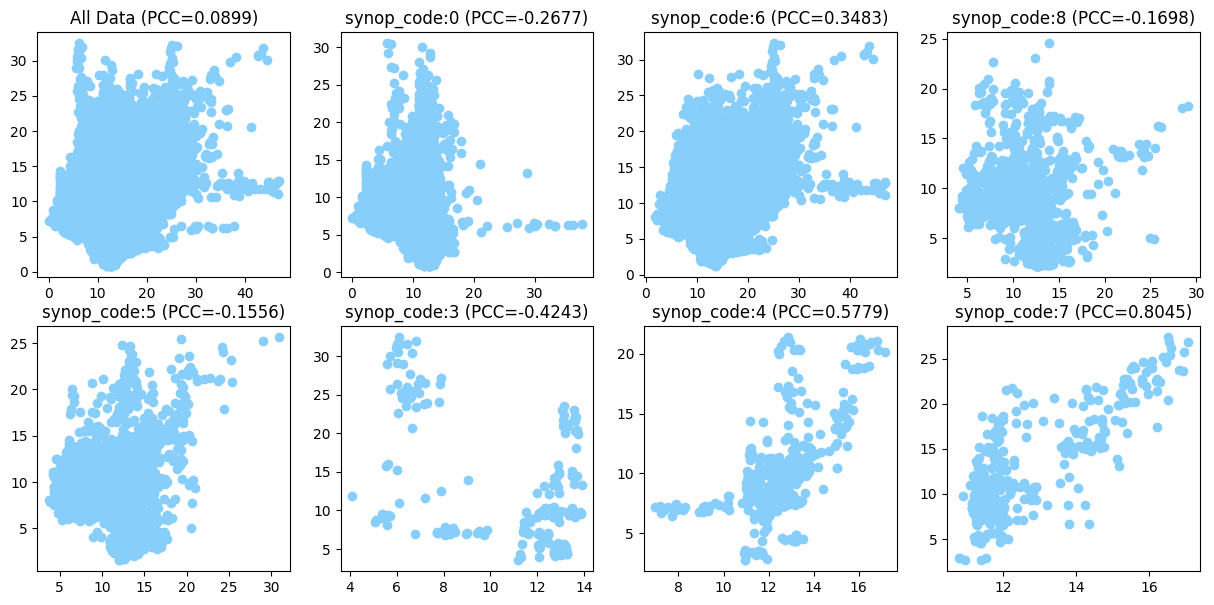

In [147]:
plt.figure(figsize=(15, 7))
plt.subplot(2,4,1)
plt.scatter(processed_data['RFL_Att'],processed_data['FSO_Att'],color='lightskyblue')
pcc_syn = np.corrcoef(processed_data['RFL_Att'], processed_data['FSO_Att'])[0, 1]
    
plt.title(f'All Data (PCC={pcc_syn:.4f})')

for i,synop_code in enumerate(processed_data['SYNOPCode'].unique()):
    plt.subplot(2,4,i+2)
    plt.scatter(processed_data[processed_data['SYNOPCode'] == synop_code]['RFL_Att'], processed_data[processed_data['SYNOPCode'] == synop_code]['FSO_Att'], label=f'SYNOP {synop_code}',color='lightskyblue')
    pcc_syn = np.corrcoef(processed_data[processed_data['SYNOPCode'] == synop_code]['RFL_Att'], processed_data[processed_data['SYNOPCode'] == synop_code]['FSO_Att'])[0, 1]
    plt.title(f'synop_code:{synop_code} (PCC={pcc_syn:.4f})')

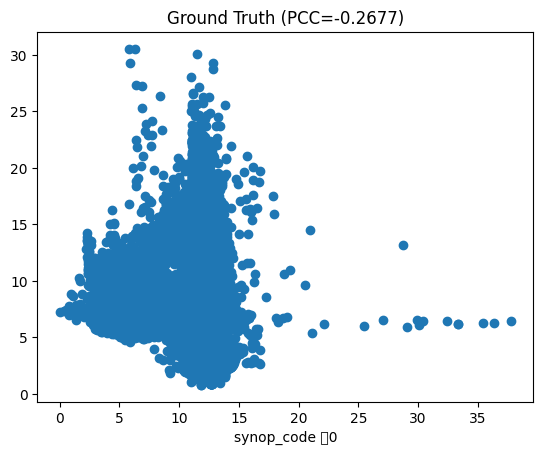

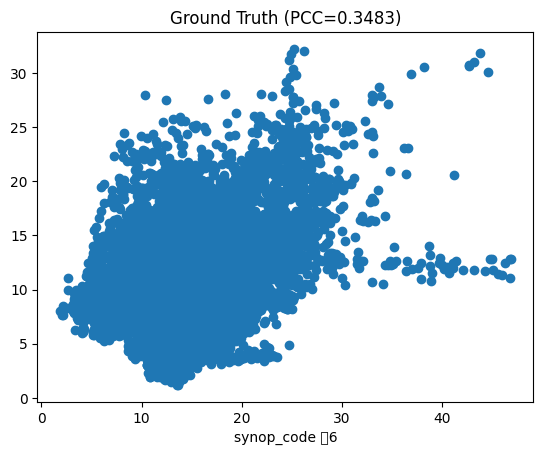

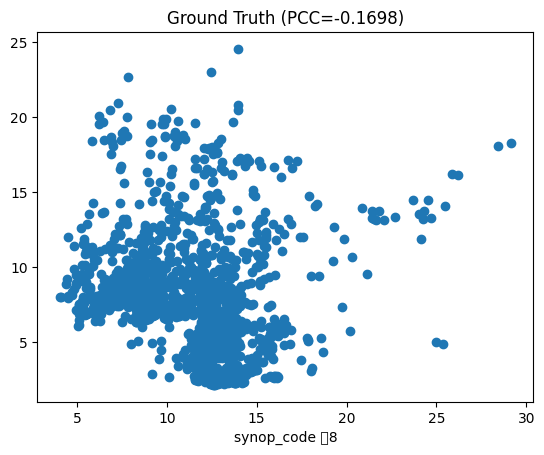

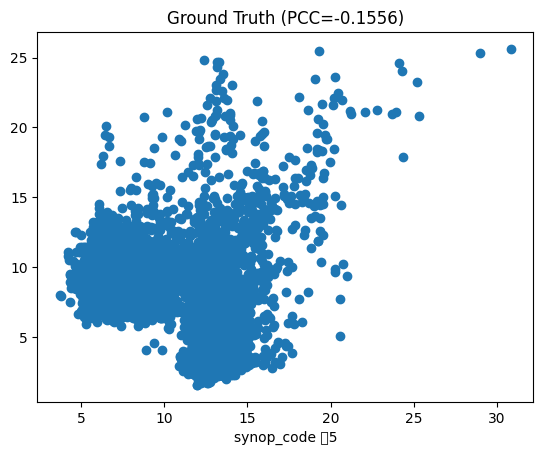

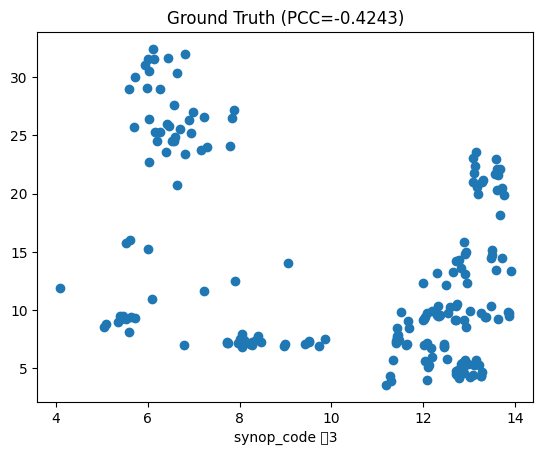

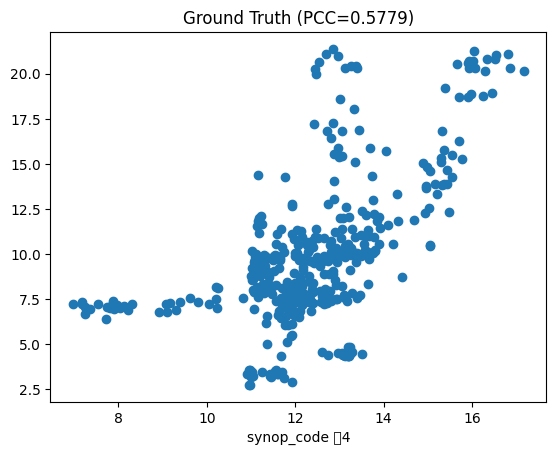

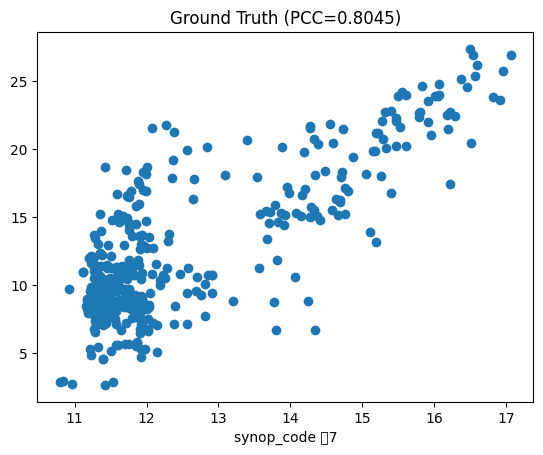

In [89]:
for synop_code in processed_data['SYNOPCode'].unique():
    plt.scatter(processed_data[processed_data['SYNOPCode'] == synop_code]['RFL_Att'], processed_data[processed_data['SYNOPCode'] == synop_code]['FSO_Att'], label=f'SYNOP {synop_code}')
    pcc_syn = np.corrcoef(processed_data[processed_data['SYNOPCode'] == synop_code]['RFL_Att'], processed_data[processed_data['SYNOPCode'] == synop_code]['FSO_Att'])[0, 1]
    plt.title(f'Ground Truth (PCC={pcc_syn:.4f})')
    plt.xlabel('synop_code ：'+str(synop_code))    
    plt.show()